In [ ]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt



In [ ]:
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

trade_active = mt5.initialize()

print(trade_active)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4200
True


In [ ]:
if not trade_active:
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')
    mt5.shutdown()

else:
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())
    print("\n")
    print(mt5.symbols_total())



{'login': 213644473, 'trade_mode': 0, 'leverage': 1000, 'limit_orders': 500, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 200.0, 'credit': 0.0, 'profit': 0.0, 'equity': 200.0, 'margin': 0.0, 'margin_free': 200.0, 'margin_level': 0.0, 'margin_so_call': 25.0, 'margin_so_so': 15.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'micheal bright omage ', 'server': 'OctaFX-Demo', 'currency': 'USD', 'company': 'Octa Markets Incorporated'}


{'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': True, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': False, 'build': 5200, 'maxbars': 100000, 'codepage': 0, 'ping_last': 150601, 'community_balance': 0.0, 'retransmission': 0.6890690676895515, 'company': 'Meta

In [ ]:
account = mt5.account_info()
terminal = mt5.terminal_info()

print(account.equity)

if(terminal.connected == True and terminal.trade_allowed == True):
    print("AI is successfully functional")
else:
    print("Please make sure metatrade 5 has internet and algo Trade is Turn On")

200.0
AI is successfully functional


In [ ]:
symbols = mt5.symbols_get()
print(len(symbols))
t_symbol = ["GBPUSD","EURUSD","USDCAD","USDJPY","AUDUSD"]
for symbol in symbols:
    for t_s in t_symbol:
        if(symbol.name == t_s):
            print("yes ",t_s)
            break



280
yes  EURUSD
yes  GBPUSD
yes  USDJPY
yes  AUDUSD
yes  USDCAD


In [ ]:
n = 0

In [ ]:
market = mt5.copy_rates_from_pos(t_symbol[n], mt5.TIMEFRAME_M30, 0, 99999)

In [ ]:
market

array([(1503012600, 1.28688, 1.28692, 1.28629, 1.28644, 1504,  8, 0),
       (1503014400, 1.28668, 1.28693, 1.28656, 1.2868 ,  183, 13, 0),
       (1503016200, 1.28677, 1.28694, 1.28643, 1.28664, 2022, 24, 0), ...,
       (1756506600, 1.35073, 1.35148, 1.35073, 1.35147, 1963, 13, 0),
       (1756508400, 1.35148, 1.35164, 1.35101, 1.35124, 1228, 13, 0),
       (1756510200, 1.35125, 1.35126, 1.34995, 1.35018, 2122, 13, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

In [ ]:
len(market)

99999

In [ ]:
data = []
for i in range(len(market)):
    data.append([market[i][1],market[i][2],market[i][3],market[i][4]])

In [ ]:
df = pd.DataFrame(data, columns=["open", "high","low", "close"])
display(df)

,open,high,low,close
0,1.28688,1.28692,1.28629,1.28644
1,1.28668,1.28693,1.28656,1.28680
2,1.28677,1.28694,1.28643,1.28664
3,1.28667,1.28741,1.28647,1.28671
4,1.28672,1.28736,1.28669,1.28711
...,...,...,...,...
99994,1.35005,1.35105,1.35003,1.35095
99995,1.35093,1.35114,1.35050,1.35073
99996,1.35073,1.35148,1.35073,1.35147
99997,1.35148,1.35164,1.35101,1.35124


In [ ]:
df.to_csv("Generated"+t_symbol[n]+" dbot.csv", index=False)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf


In [2]:
train_df = pd.read_csv("GeneratedGBPUSD dbot.csv")
display(train_df)

,open,high,low,close
0,1.28688,1.28692,1.28629,1.28644
1,1.28668,1.28693,1.28656,1.28680
2,1.28677,1.28694,1.28643,1.28664
3,1.28667,1.28741,1.28647,1.28671
4,1.28672,1.28736,1.28669,1.28711
...,...,...,...,...
99994,1.35005,1.35105,1.35003,1.35095
99995,1.35093,1.35114,1.35050,1.35073
99996,1.35073,1.35148,1.35073,1.35147
99997,1.35148,1.35164,1.35101,1.35124


In [11]:
# -------------------------
# User-adjustable settings
# -------------------------
SEQ_LEN = 48              # length of input sequence (timesteps). Typical choices: 30, 60, 90
MODEL_SAVE_PATH = 'lstm_multivar_best.keras'

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [5]:
def create_sequences(data_scaled, seq_len):
    """
    data_scaled: np.array shaped (n_rows, n_features)
    returns X (n_samples, seq_len, n_features), y (n_samples, n_features)
    where y is the row immediately following the window.
    """
    X, y = [], []
    n_rows = data_scaled.shape[0]
    for i in range(n_rows - seq_len):
        X.append(data_scaled[i:i+seq_len])
        y.append(data_scaled[i+seq_len])
    X = np.array(X)
    y = np.array(y)
    return X, y

# 1) Convert to numpy and ensure numeric
n_rows, n_features = train_df.values.shape
"""
# 2) Fit scaler on all feature columns (important to use same scaler for inverse transform)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_all = scaler.fit_transform(train_df.values)  # (n_rows, n_features)
"""
# 3) Build sequences
X, y = create_sequences(train_df.values, SEQ_LEN)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)

n_samples = X.shape[0]


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None, shuffle=False)

In [8]:
X_val, X_test, y_val,  y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=None, shuffle=False)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)


(74963, 48, 4)
(74963, 4)
(6247, 48, 4)
(6247, 4)
(18741, 48, 4)
(18741, 4)


In [13]:
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt


import json
import math
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [15]:
  # 5) Build model
seq_len = X_train.shape[1]
n_features = X_train.shape[2]
output_dim = y_train.shape[1]

i = Input(shape=(seq_len, n_features))
X = LSTM(100, return_sequences=True)(i)
X = LSTM(100, return_sequences=True)(X)
X = LSTM(100, return_sequences=True)(X)
X = LSTM(100)(X)
X = Dense(100, activation="relu")(X)
X = Dropout(0.25)(X)
X = Dense(output_dim)(X)

model = Model(i, X)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 48, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 48, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 48, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 293,704 (1.12 MB)

 Trainable params: 293,704 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 6) Callbacks
es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, verbose=2)

In [17]:
model.compile(optimizer="Adam",
                  loss='mse',
                  metrics=['mae'])


In [18]:
r = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[es, rlr, mc ],
    verbose=2

)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.00001, saving model to lstm_multivar_best.keras
4686/4686 - 70s - 15ms/step - loss: 0.0184 - mae: 0.0976 - val_loss: 1.2845e-05 - val_mae: 0.0030 - learning_rate: 1.0000e-03
Epoch 2/100

Epoch 2: val_loss did not improve from 0.00001
4686/4686 - 65s - 14ms/step - loss: 0.0010 - mae: 0.0224 - val_loss: 1.1188e-04 - val_mae: 0.0103 - learning_rate: 1.0000e-03
Epoch 3/100

Epoch 3: val_loss did not improve from 0.00001
4686/4686 - 82s - 18ms/step - loss: 1.3111e-04 - mae: 0.0084 - val_loss: 2.7183e-05 - val_mae: 0.0050 - learning_rate: 1.0000e-03
Epoch 4/100

Epoch 4: val_loss did not improve from 0.00001
4686/4686 - 84s - 18ms/step - loss: 1.2416e-04 - mae: 0.0081 - val_loss: 1.0140e-04 - val_mae: 0.0100 - learning_rate: 1.0000e-03
Epoch 5/100

Epoch 5: val_loss improved from 0.00001 to 0.00000, saving model to lstm_multivar_best.keras
4686/4686 - 85s - 18ms/step - loss: 1.1831e-04 - mae: 0.0079 - val_loss: 4.8688e-06 - val_mae: 0.001

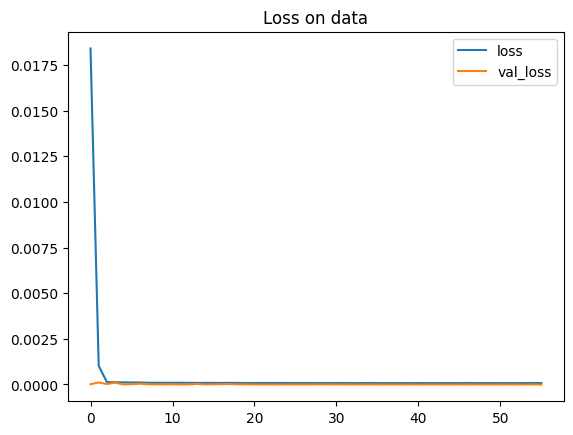

In [19]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

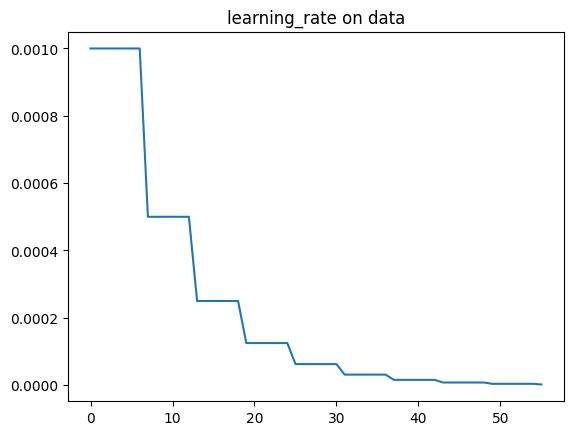

In [20]:
plt.title("learning_rate on data")
plt.plot(r.history['learning_rate'], label="loss")

plt.show()

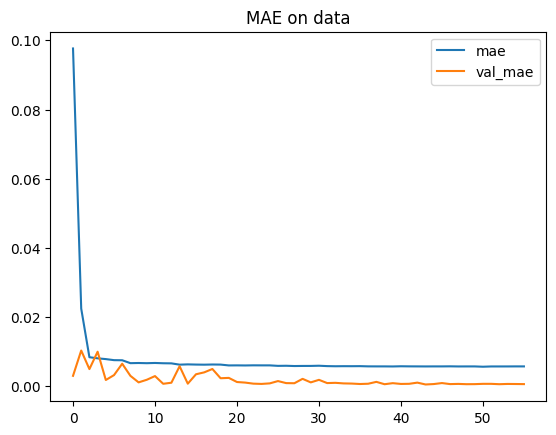

In [21]:
plt.title("MAE on data")
plt.plot(r.history['mae'], label="mae")
plt.plot(r.history['val_mae'], label="val_mae")
plt.legend()
plt.show()

In [22]:
from tensorflow.keras.models import load_model
best_model = load_model(MODEL_SAVE_PATH)